In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [3]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [4]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [5]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [6]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [7]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [8]:
len(df)

25867

In [9]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [10]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [11]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean() + 3
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

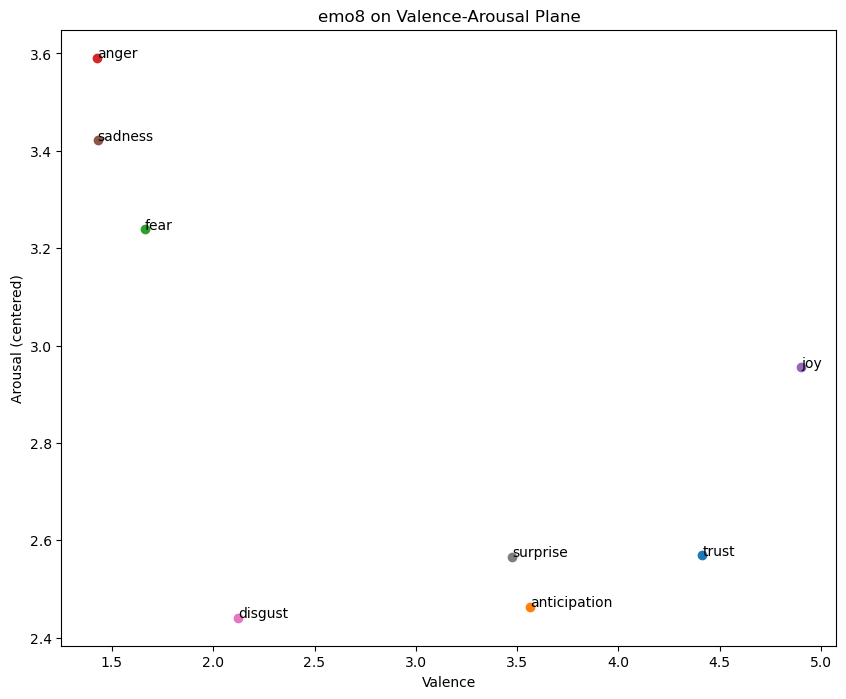

In [13]:
plt.figure(figsize=(10, 8))
for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)
plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [14]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [15]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [16]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [17]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [18]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [19]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [20]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [21]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [22]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

In [23]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

# Baseline model using the logits of the base models directly

## Torch

In [24]:
from deepproblog.utils.standard_networks import MLP

baseline_model = MLP(
    372,        # input size
    256, 128,   # hidden layers
    8,          # number of emotion classes
    activation=nn.ReLU,
    softmax=False,   # important!
    batch=True
)
criterion = nn.CrossEntropyLoss()
baseline_model.to(DEVICE)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

In [25]:
class BaselineFeatureDataset(TorchDataset):
    """Dataset that provides pre-computed features as tensors"""
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir
    
    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)
            
        data_file = os.path.join(self.feature_dir, f"sample_{idx}.pt")
        data = torch.load(data_file)
        return data["features"].to(DEVICE), data["label"]
    
    def __len__(self):
        return len(self.indices)

In [26]:
baseline_features_train = BaselineFeatureDataset(train_indices, feature_dir=os.path.join(data_dir, "presaved_logits"))
baseline_features_test = BaselineFeatureDataset(test_indices, feature_dir=os.path.join(data_dir, "presaved_logits"))

In [27]:
baseline_train_loader = DataLoader(baseline_features_train, batch_size=32, shuffle=True)
baseline_test_loader = DataLoader(baseline_features_test, batch_size=32, shuffle=False)

In [28]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples

In [29]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, criterion):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels))
    )
    
    # Overall metrics
    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:     {results['loss']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Epoch 1/5


Train Loss: 1.6964, Train Accuracy: 0.3663



Overall Metrics:
Loss:     1.5882
Accuracy: 0.4186

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.3682       0.2494       0.2974       437       
anticipation    0.3544       0.4992       0.4145       1214      
disgust         0.0000       0.0000       0.0000       187       
fear            0.2508       0.1995       0.2222       386       
joy             0.5046       0.7989       0.6185       1571      
sadness         0.3239       0.2751       0.2975       418       
surprise        0.0000       0.0000       0.0000       186       
trust           0.2105       0.0052       0.0101       775       
----------------------------------------------------------------------
Macro Avg       0.2516       0.2534       0.2325       5174      
Weighted Avg    0.3439       0.4186       0.3523       5174      


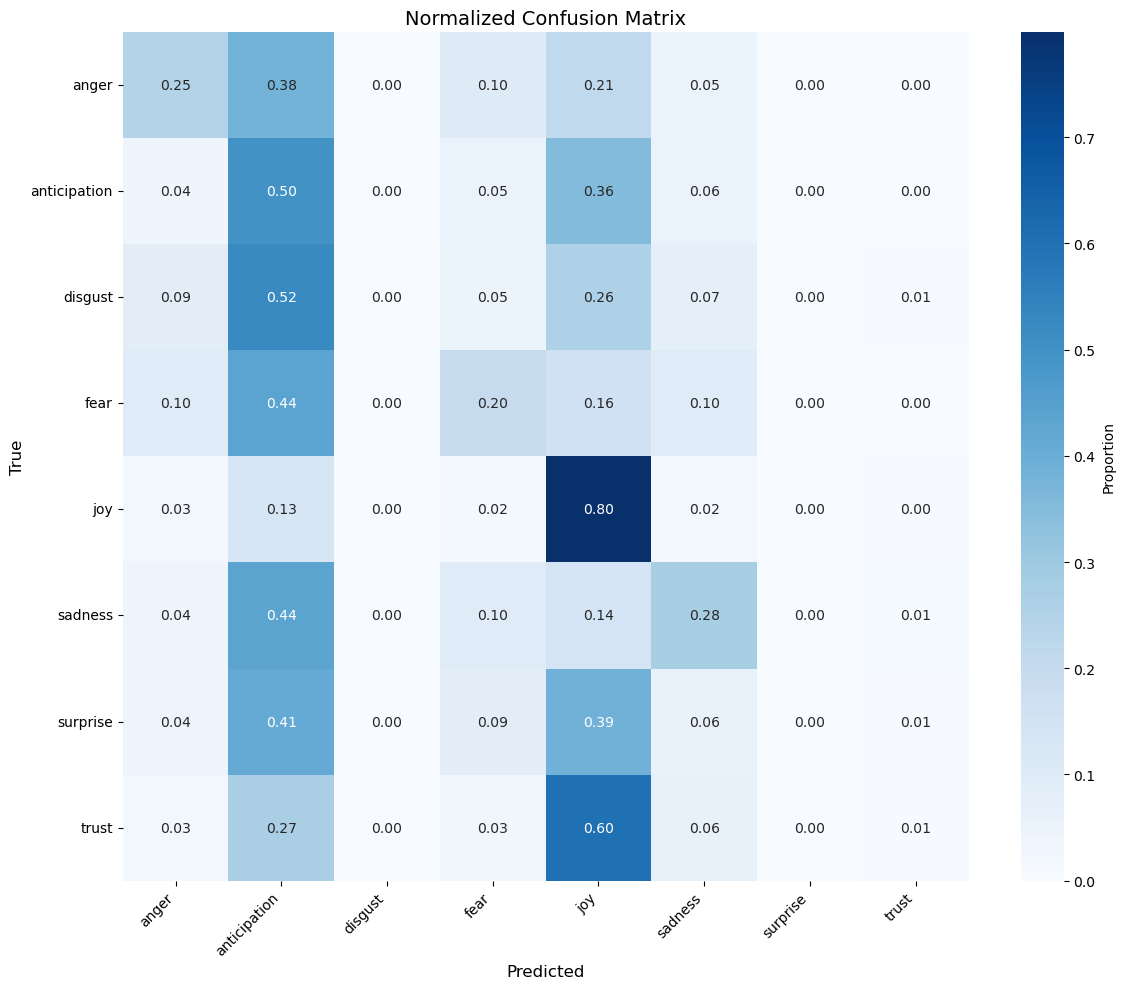


Epoch 2/5


Train Loss: 1.6271, Train Accuracy: 0.3980



Overall Metrics:
Loss:     1.5410
Accuracy: 0.4366

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.4706       0.1831       0.2636       437       
anticipation    0.3474       0.7372       0.4723       1214      
disgust         0.0000       0.0000       0.0000       187       
fear            0.2986       0.1114       0.1623       386       
joy             0.5975       0.6868       0.6390       1571      
sadness         0.4097       0.2225       0.2884       418       
surprise        0.0000       0.0000       0.0000       186       
trust           0.2749       0.0890       0.1345       775       
----------------------------------------------------------------------
Macro Avg       0.2998       0.2538       0.2450       5174      
Weighted Avg    0.3992       0.4366       0.3827       5174      


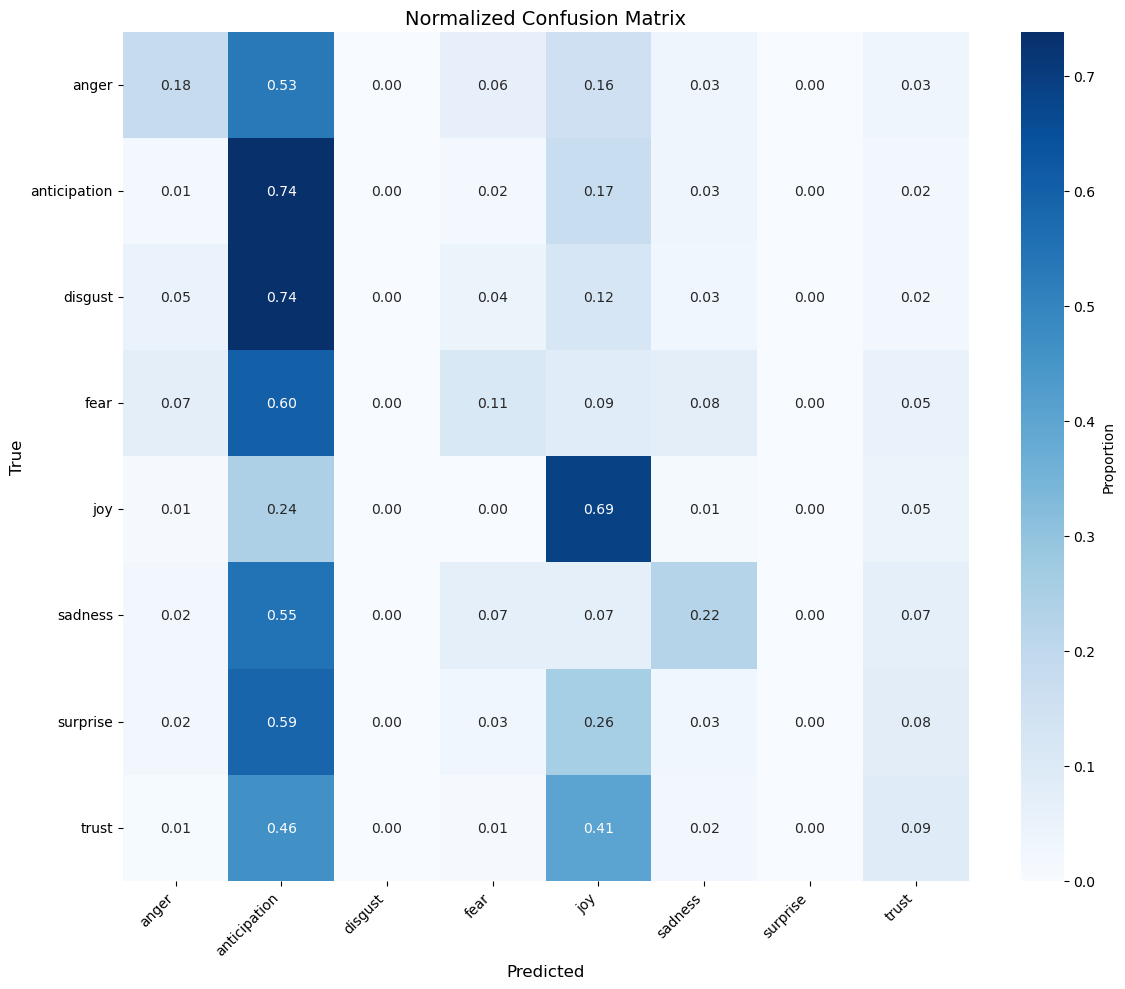


Epoch 3/5


Train Loss: 1.6031, Train Accuracy: 0.4090



Overall Metrics:
Loss:     1.5202
Accuracy: 0.4378

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.3828       0.2654       0.3135       437       
anticipation    0.3811       0.5082       0.4356       1214      
disgust         0.0000       0.0000       0.0000       187       
fear            0.3333       0.0984       0.1520       386       
joy             0.5013       0.8288       0.6248       1571      
sadness         0.3583       0.3660       0.3621       418       
surprise        0.0000       0.0000       0.0000       186       
trust           0.3421       0.0503       0.0877       775       
----------------------------------------------------------------------
Macro Avg       0.2874       0.2647       0.2470       5174      
Weighted Avg    0.3790       0.4378       0.3721       5174      


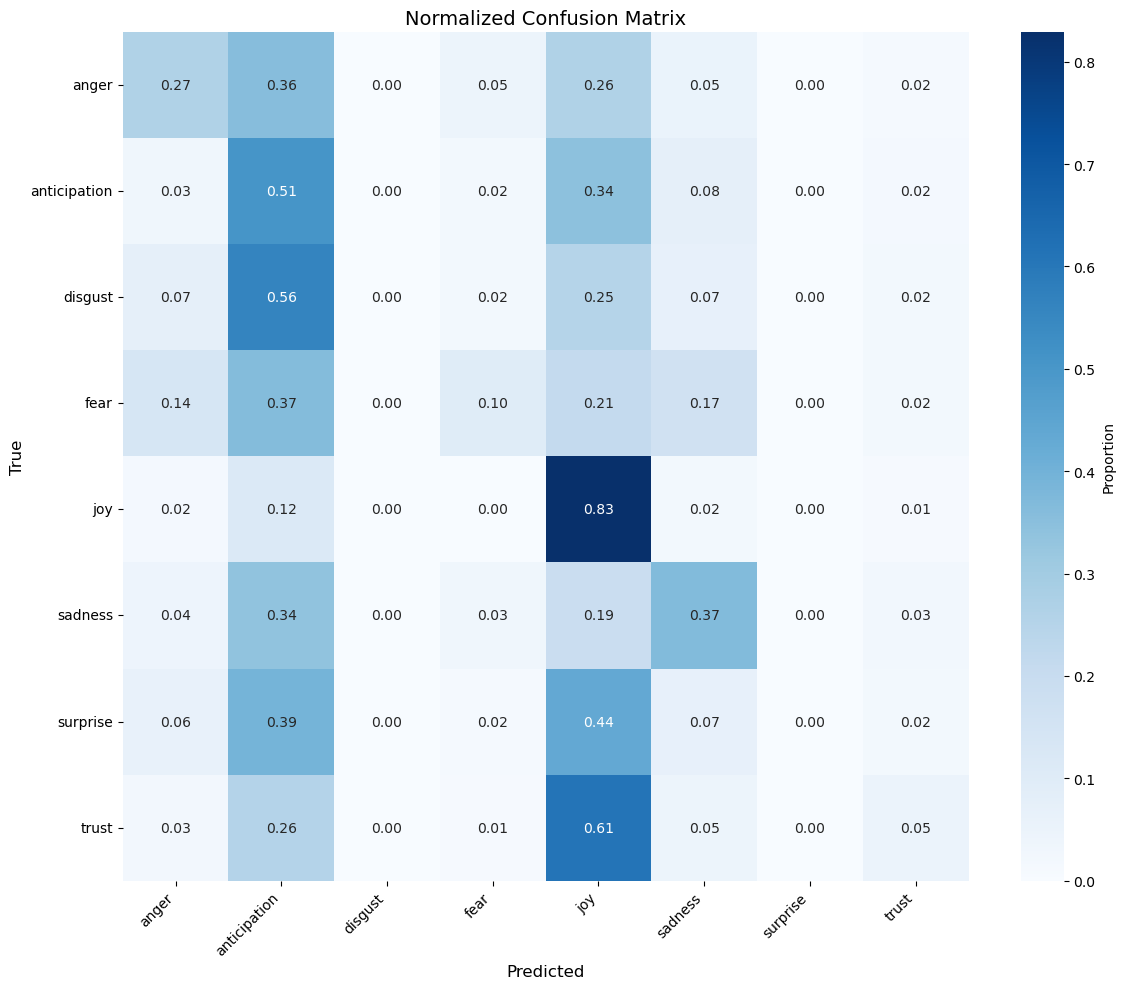


Epoch 4/5


Train Loss: 1.5890, Train Accuracy: 0.4136



Overall Metrics:
Loss:     1.4989
Accuracy: 0.4561

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.4025       0.3638       0.3822       437       
anticipation    0.4276       0.5008       0.4613       1214      
disgust         0.0000       0.0000       0.0000       187       
fear            0.3166       0.1632       0.2154       386       
joy             0.5529       0.7524       0.6374       1571      
sadness         0.3295       0.5550       0.4135       418       
surprise        0.0000       0.0000       0.0000       186       
trust           0.3671       0.1497       0.2126       775       
----------------------------------------------------------------------
Macro Avg       0.2995       0.3106       0.2903       5174      
Weighted Avg    0.4074       0.4561       0.4154       5174      


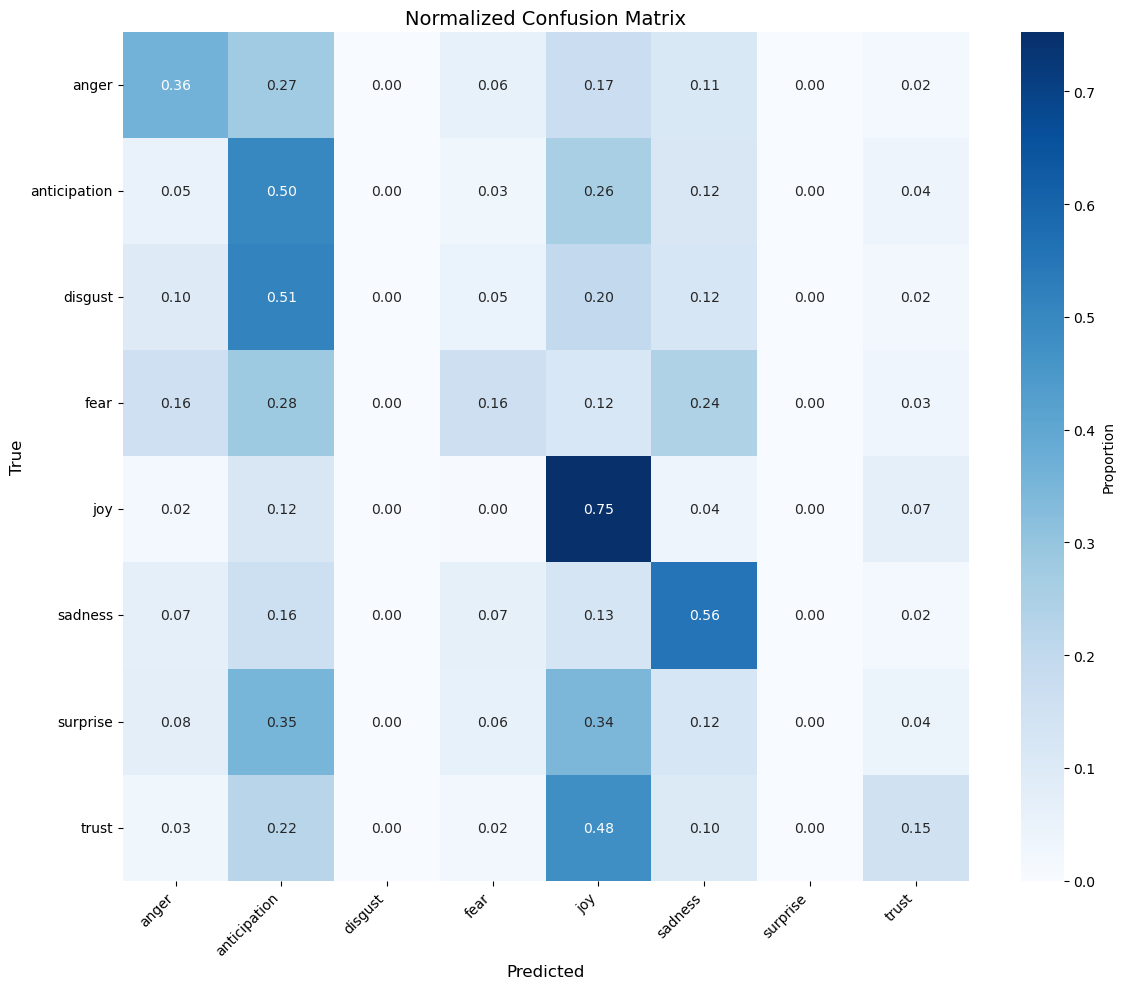


Epoch 5/5


Train Loss: 1.5687, Train Accuracy: 0.4259



Overall Metrics:
Loss:     1.4871
Accuracy: 0.4600

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.4939       0.1854       0.2696       437       
anticipation    0.3798       0.6244       0.4723       1214      
disgust         0.0000       0.0000       0.0000       187       
fear            0.3122       0.1917       0.2376       386       
joy             0.5710       0.7658       0.6542       1571      
sadness         0.3829       0.4617       0.4187       418       
surprise        0.0000       0.0000       0.0000       186       
trust           0.4277       0.0916       0.1509       775       
----------------------------------------------------------------------
Macro Avg       0.3209       0.2901       0.2754       5174      
Weighted Avg    0.4225       0.4600       0.4064       5174      


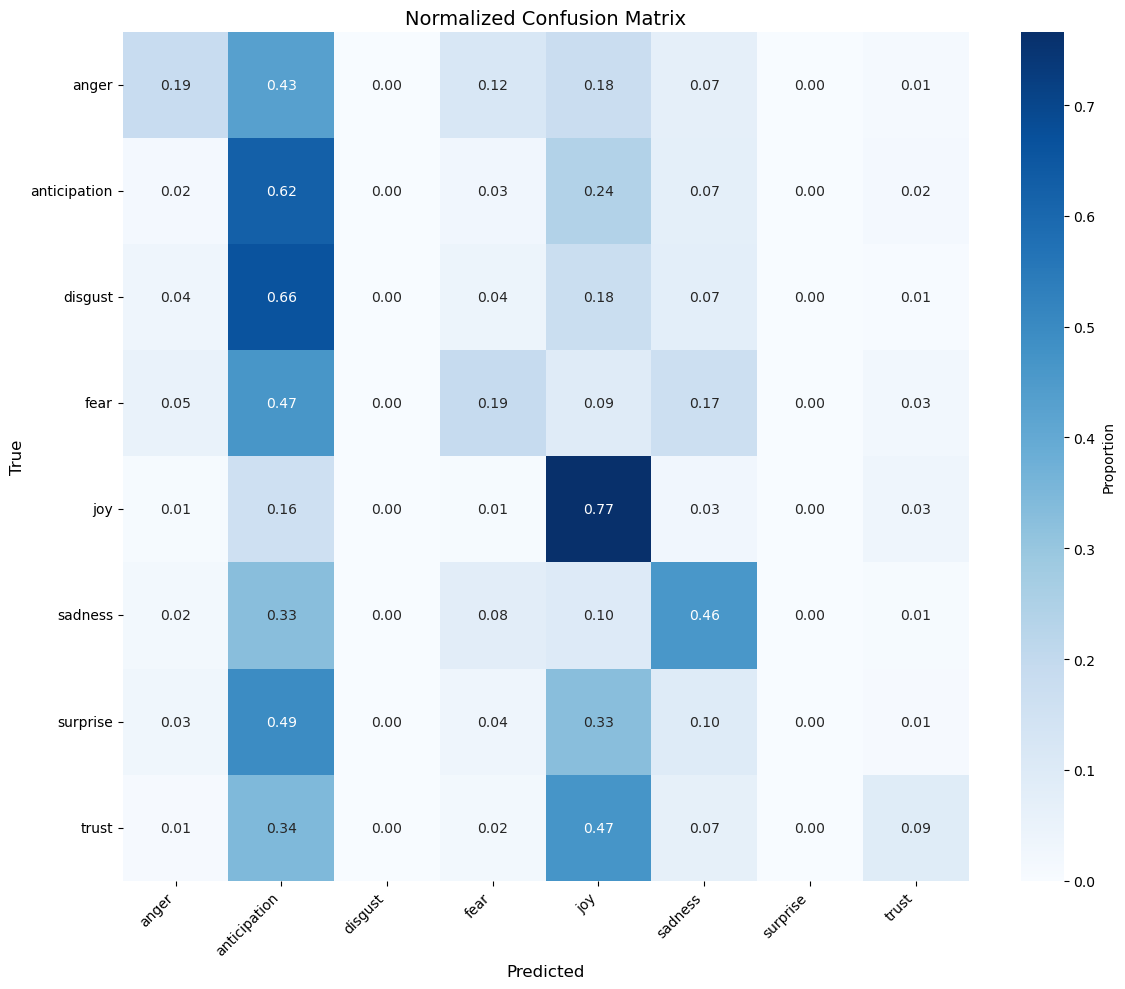

In [ ]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
#     # Train
#     train_loss, train_acc = train_epoch(baseline_model, baseline_train_loader, optimizer, criterion)
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
#     # Evaluate
#     results = evaluate_with_metrics(baseline_model, baseline_test_loader, criterion)
#     print_detailed_metrics(results, fe_labels)
    
#     # Plot confusion matrix
#     plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)

# torch.save(baseline_model.state_dict(), os.path.join(model_dir, "baseline_emotion_model.pth"))
# # Load the trained baseline model weights
# # baseline_dpl.load_state_dict(torch.load(os.path.join(model_dir, "baseline_emotion_model_2.pth")))

## DPL

In [31]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        return self.module(*args, **kwargs)
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [32]:
baseline_dpl_raw = MLP(
    372,        # input size
    256, 128,   # hidden layers
    8,          # number of emotion classes
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
baseline_dpl = DeviceAwareModule(baseline_dpl_raw).to(DEVICE)

baseline_dpl_network = Network(baseline_dpl, "baseline_dpl", batching=True)
baseline_dpl_network.optimizer = torch.optim.Adam(baseline_dpl.parameters(), lr=1e-3)

In [33]:
baseline_dpl_network = Network(baseline_dpl, "baseline_dpl", batching=True)
baseline_dpl_network.optimizer = torch.optim.Adam(baseline_dpl.parameters(), lr=1e-3)  

In [34]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [35]:
class BaselineDPLFeatureDataset(DPLDataset):
    """Dataset that loads pre-computed features from disk for DeepProbLog"""
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir
    
    def __getitem__(self, idx):
        # Handle different input types
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)
        
        # Load the pre-saved tensor from disk
        data_file = os.path.join(self.feature_dir, f"sample_{idx}.pt")
        data = torch.load(data_file, map_location='cpu')
        
        # Return ONLY the features tensor (no label!)
        # DeepProbLog handles labels separately via the Query
        return data["features"].cpu()
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        # Not used by DPL tensor sources
        pass

baseline_dpl_features_train = BaselineDPLFeatureDataset(train_indices, feature_dir=os.path.join(data_dir, "presaved_logits"))
baseline_dpl_features_test = BaselineDPLFeatureDataset(test_indices, feature_dir=os.path.join(data_dir, "presaved_logits"))

In [36]:
baseline_dpl_model = Model(os.path.join(prolog_dir, "baseline_model.pl"), [baseline_dpl_network])
baseline_dpl_model.set_engine(ExactEngine(baseline_dpl_model))

baseline_dpl_model.add_tensor_source("features_train", baseline_dpl_features_train)
baseline_dpl_model.add_tensor_source("features_test", baseline_dpl_features_test)

In [37]:
class BaselineDPLDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        pass

    def to_query(self, idx):
        img_idx = self.indices[idx]
        label_str = df.loc[img_idx]['emotion']
        label = Constant(LABEL_TO_ID[label_str])
        
        # Create query with tensor reference (not the actual tensor!)
        return Query(
            Term("final_emo",
                 Term("tensor", Term(f"features_{self.dataset_name}", Constant(img_idx))),
                 label)
        )

In [38]:
baseline_dpl_train = BaselineDPLDataset(train_indices, "train")
baseline_dpl_test = BaselineDPLDataset(test_indices, "test")

In [39]:
baseline_dpl_train_loader = DPLDataLoader(baseline_dpl_train, batch_size=32, shuffle=True)
baseline_dpl_test_loader = DPLDataLoader(baseline_dpl_test, batch_size=32, shuffle=False)

In [ ]:
train_obj = train_model(
    baseline_dpl_model,
    baseline_dpl_train_loader,
    10,
    log_iter=32
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  32 	s:10.9912 	Average Loss:  1.8257555500313174
Iteration:  64 	s:10.4073 	Average Loss:  1.7637691741110757
Iteration:  96 	s:9.5234 	Average Loss:  1.8085846809408395
Iteration:  128 	s:11.1727 	Average Loss:  1.7741515235538827
Iteration:  160 	s:10.8763 	Average Loss:  1.7592055570421508
Iteration:  192 	s:11.9015 	Average Loss:  1.7053080309924553
Iteration:  224 	s:11.6483 	Average Loss:  1.6935778762344853
Iteration:  256 	s:11.3070 	Average Loss:  1.6675463257652154
Iteration:  288 	s:10.7788 	Average Loss:  1.7050468898305553
Iteration:  320 	s:10.7377 	Average Loss:  1.6229569756724231
Iteration:  352 	s:10.9573 	Average Loss:  1.6799197320215171
Iteration:  384 	s:11.2414 	Average Loss:  1.6843950553156901
Iteration:  416 	s:10.6077 	Average Loss:  1.7231440549585386
Iteration:  448 	s:10.3564 	Average Loss:  1.6865604660997633
Iteration:  480 	s:9.2089 	Average Loss:  1.7030612514499808
Iteration:  512 	s:10.3415 	Average Loss: 

In [41]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert to numpy arrays with label indices
    label_to_idx = {str(i): i for i in range(len(fe_labels))}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [42]:
results = evaluate_dpl_with_metrics(baseline_dpl_model, baseline_dpl_test)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.39350599149594123

Overall Metrics:
Accuracy: 0.3935

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.3209       0.4031       0.3573       511       
anticipation    0.3368       0.4083       0.3691       1183      
disgust         0.5000       0.0050       0.0100       199       
fear            0.2887       0.0889       0.1360       461       
joy             0.4733       0.7705       0.5864       1416      
sadness         0.3893       0.3125       0.3467       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.2269       0.0745       0.1121       725       
----------------------------------------------------------------------
Macro Avg       0.3170       0.2579       0.2397       5174      
Weighted Avg    0.3535       0.3935       0.3427       5174      


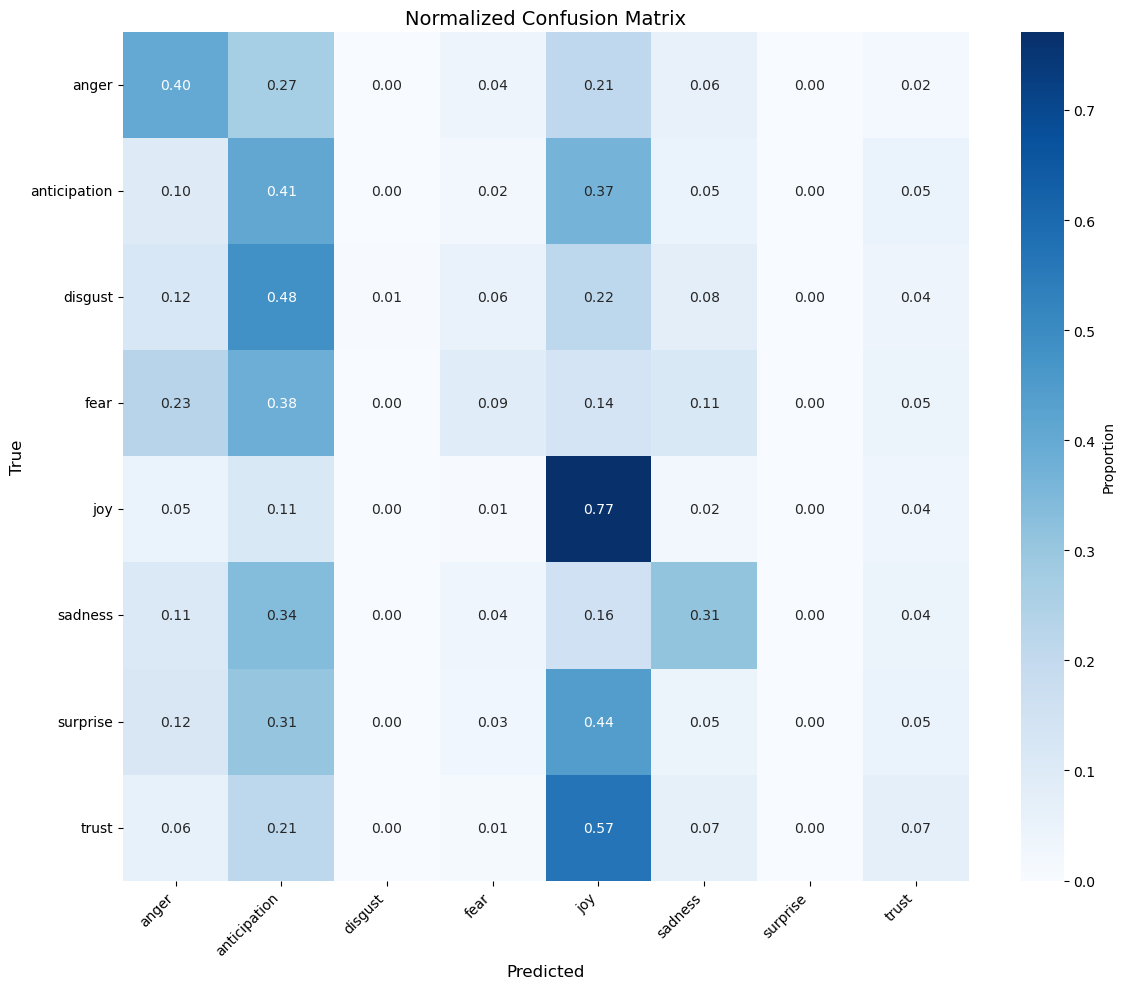

In [43]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)

# DPL with symbolic knowledge about the data

In [ ]:
class FaceNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        outputs = self.base_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        return probs
    
face_model = FaceNet(face_model_base)
face_model.to(DEVICE)
print("Face model initialized")

In [ ]:
for p in face_model.parameters():
    p.requires_grad = False

In [ ]:
face_network = Network(face_model, "face_model", batching=True)
face_network.optimizer = torch.optim.Adam(face_model.parameters(), lr=lr_faces)
face_network.optimizer = None

In [ ]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, f"scene_clusters_{nr_clusters}.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)
categories_365_df.head()

# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

mapped_categories = list(dict.fromkeys(category_mapping.values()))
print("Mapped Categories:", mapped_categories)

# Check for all the columns in the excel (without the first row) if there are no duplicates and the length is 365
cats = []
for col in categories_365_df.columns:
    unique_cats = categories_365_df[col].dropna().tolist()
    cats.extend(unique_cats)
unique_set = set(cats)
print("Total unique categories mapped:", len(unique_set))  # Should be 365

errors = 0
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)
        errors += 1

# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)
        errors += 1

assert(errors == 0)

# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0


def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    return str(scene_categories[scene_idx_365]) + " -> " + str(mapped_categories[mapped_idx])

In [ ]:
class SceneNet(nn.Module):
    def __init__(self, pretrained_model, map_365 = map_365):
        super().__init__()
        self.base = pretrained_model
        self.register_buffer("map_365", map_365.clone().float())

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        logits = self.base(x)
        probs = torch.softmax(logits, dim=1)
        mapped_probs = torch.matmul(probs, self.map_365)
        return mapped_probs

for p in scene_model_base.parameters():
    p.requires_grad = False

scene_model = SceneNet(pretrained_model=scene_model_base).to(DEVICE)      

scene_network = Network(scene_model, "scene_model", batching=True)
scene_network.optimizer = None

scene_network.optimizer = torch.optim.Adam(scene_model.parameters(), lr=lr_scenes)  


In [ ]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    face_model.eval()
    scene_model.eval()
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        # Get face predictions
        face_tensor = faces_dataset[(sample_idx, face_rank)]
        model_output = face_model(face_tensor.unsqueeze(0).to(DEVICE))
        probs = model_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_tensor = scenes_dataset[(sample_idx,)]
    
    with torch.no_grad():
        base_logits = scene_model_base(scene_tensor.unsqueeze(0).to(DEVICE))
        base_probs = torch.softmax(base_logits, dim=1)[0]

        mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(base_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {get_mapped_category(idx)}: {prob:.4f}")
    print("")
    # Show top 3 from mapped model (20 categories)
    top3_mapped = torch.topk(mapped_output, 3)
    print("Mapped model (20 categories):")
    for prob, idx in zip(top3_mapped.values.cpu(), top3_mapped.indices.cpu()):
        print(f"  {mapped_categories[idx]} ({idx}): {prob:.4f}")


In [ ]:
def show_images_with_context(context = None, threshold = 0.10, indices = indices, max_images=10, k=3):
    scene_model.eval()
    found_with_context = 0
    random.shuffle(indices)
    print(len(indices))
    for sample_idx in indices:
        scene_tensor = scenes_dataset[(sample_idx,)]

        with torch.no_grad():
            mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

        top_mapped = torch.topk(mapped_output, k)
        top_categories = [mapped_categories[idx.item()] for idx in top_mapped.indices.cpu()]

        # The probability of the context in the top 3 needs to exceed 10%
        top_probs = torch.softmax(mapped_output, dim=0)[top_mapped.indices]
        context_prob = 0
        if context in top_categories:
            context_index = top_categories.index(context)
            context_prob = top_probs[context_index].item()

        if context is None or context_prob > threshold:
            show_pretrained_model_predictions_on_sample(sample_idx)
            found_with_context += 1
            if found_with_context >= max_images:
                    break


In [65]:
class FindingEmoDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        super(FindingEmoDataset, self).__init__()
        self.indices = indices
        self.dataset_name = dataset_name
    
    def __getitem__(self, i):
        pass
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        index = self.indices[i]
        row = df.loc[index]
        nr_faces = row['nr_faces']
        sub_images = [Term("face_{}".format(x)) for x in range(nr_faces)]
        images = [
            Term("tensor", Term(f"faces_{self.dataset_name}", Constant(index), Constant(x))) for x in range(nr_faces)
        ]

        sub = {sub_images[x]: images[x] for x in range(nr_faces)}
        return Query(
            Term(f"final_emotion",
                 list2term(sub_images),
                 Term("tensor", Term(f"scenes_{self.dataset_name}", Constant(index))),
                 Term(row['emotion'])
            ),
            substitution=sub,
        )
    
train_dataset = FindingEmoDataset(train_indices, "train")
test_dataset = FindingEmoDataset(test_indices, "test")

In [67]:
train_dataset.to_query(0)

(1.0::final_emotion([face_0, face_1, face_2, face_3, face_4],tensor(scenes_train(2405)),joy), {face_0: tensor(faces_train(2405,0)), face_1: tensor(faces_train(2405,1)), face_2: tensor(faces_train(2405,2)), face_3: tensor(faces_train(2405,3)), face_4: tensor(faces_train(2405,4))})

In [66]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size)

In [ ]:
train_obj = train_model(
    model,
    train_loader,
    10,
    log_iter=log_iter
)

# model.save_state(os.path.join(model_dir, "model5OH_freezed.zip"))

Training  for 10 epoch(s)
Epoch 1
Iteration:  2 	s:30.4448 	Average Loss:  2.7015645764768124
Iteration:  4 	s:57.5859 	Average Loss:  5.073209382593632
Iteration:  6 	s:57.3355 	Average Loss:  4.991621445864439
Iteration:  8 	s:58.0840 	Average Loss:  5.089779078960419
Iteration:  10 	s:61.1032 	Average Loss:  5.318948857486248
Iteration:  12 	s:62.8583 	Average Loss:  5.091534528881311
Iteration:  14 	s:58.7764 	Average Loss:  5.06160930916667
Iteration:  16 	s:59.2890 	Average Loss:  4.8659720085561275
Iteration:  18 	s:63.1453 	Average Loss:  5.047756910324097
Iteration:  20 	s:57.9402 	Average Loss:  4.847430791705847
Iteration:  22 	s:61.3882 	Average Loss:  5.080404300242662
Iteration:  24 	s:61.7823 	Average Loss:  4.938459079712629
Iteration:  26 	s:59.1182 	Average Loss:  5.036342024803162
Iteration:  28 	s:66.9624 	Average Loss:  5.06562514975667
Iteration:  30 	s:57.6961 	Average Loss:  5.032894648611546
Iteration:  32 	s:64.8764 	Average Loss:  5.011751249432564
Iteration:

KeyboardInterrupt: 

In [264]:
def test_query(query, model):
    model.eval()
    results = model.solve([query])
    result = results[0].result
    print(result)

In [ ]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result